In [1]:
import sys
import io
import os
import pandas as pd

import rdkit

# lives in src/rdkit_ipynb_tools
import rdkit_ipynb_tools

from bokeh.plotting import output_notebook
import holoviews
import param
import panel as pn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
output_notebook(hide_banner=True)
from IPython.display import display, HTML

from holoviews.operation.datashader import datashade, rasterize, shade, dynspread
from holoviews.plotting.util import process_cmap
from holoviews.operation import decimate
decimate.max_samples = 5000

import datashader
from datashader.colors import viridis
from datashader.colors import colormap_select
from datashader.transfer_functions import set_background
import colorcet as cc

#holoviews.extension('bokeh', logo=False)

%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


In [2]:
import sys
sys.version

'3.12.1 (main, Jan 15 2024, 10:35:30) [GCC 13.2.0]'

In [3]:
# Paths are relative to being in the src directory

D4_screen_100k = pd.read_parquet("../intermediate_data/D4_screen_100k.parquet")
D4_screen_100k['Binder'] = -1
D4_in_vitro = pd.read_csv("../data/D4_in_vitro_data.csv")
D4_in_vitro['dockscore'] = D4_in_vitro['score']
D4_in_vitro = D4_in_vitro[['zincid', 'smiles', 'score', 'hac', 'Binder']]

# concat across rows
data = pd.concat([D4_screen_100k, D4_in_vitro])
substance_id_field = "zincid"
smiles_field = "smiles"
label_field = "zincid"


embedding_tag = "embedding_screen_100k_in_vitro_unimol2_cosine"
embedding = pd.read_parquet(path = f"../intermediate_data/{embedding_tag}/umap_embedding.parquet")

data["UMAP_1"] = embedding["UMAP_1"]
data["UMAP_2"] = embedding["UMAP_2"]


In [4]:
data[[substance_id_field, smiles_field, label_field, "UMAP_1", "UMAP_2"]]

,zincid,smiles,zincid,UMAP_1,UMAP_2
0,ZINC000610599051,Cn1c(C(=O)NC[C@@H]2CCC[C@@]23NC(=O)N(C)C3=O)cc...,ZINC000610599051,13.372310,-5.367706
1,ZINC000597880560,CO[C@@H](CNC(=O)c1cc([N+](=O)[O-])cnc1C)[C@@H]...,ZINC000597880560,6.425935,10.145303
2,ZINC000680753831,CCc1cccnc1-c1noc(CCN2CCCC2=O)n1,ZINC000680753831,7.095874,11.472702
3,ZINC000043182584,Cc1[nH]ncc1CCCNC(=O)N[C@H](C)c1cccc(Cl)c1,ZINC000043182584,8.094478,7.494432
4,ZINC000281855501,CN(CCCN1CCCC1)C(=O)CS(=O)(=O)CCCc1ccccc1,ZINC000281855501,12.924946,-4.412998
...,...,...,...,...,...
547,ZINC000664448457,CC1C[C@H]2CC[C@@H](C1)N2C(=O)C(=O)c1ccc(F)cc1,ZINC000664448457,2.625134,3.624592
548,ZINC000621433144,CC(C)N1C[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)[C@@H]...,ZINC000621433144,6.039416,9.645512
549,ZINC000361131264,CC(C)N1C[C@@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]...,ZINC000361131264,6.570454,11.660230
550,ZINC000361131265,CC(C)N1C[C@@H](C)[C@@H](NC(=O)N2Cc3ccccc3[C@@H...,ZINC000361131265,5.994603,11.285159


In [5]:
def view_UMAP(
        embedding,
        label='',
        inv_color=False,
        color_pallet=viridis,
        background_color=None):
    """Return a HoloMap of a UMAP Embedding

    Input: embedding: Embedding with columns [<cell_meta_columns>, 'UMAP_1', 'UMAP_2']
           label: text label for the plot
    Output: A resizable HoloMap with tooltips with cell_meta columns for a sample of points
    """
    points = holoviews.Points(embedding, ['UMAP_1', 'UMAP_2'], label=label)
    map = rasterize(points)

    if inv_color:
        colormap = colormap_select(color_pallet[::-1])
    else:
        colormap = colormap_select(color_pallet)
    map = shade(map, cmap=colormap)
    map = dynspread(map, threshold=0.5)
    if (background_color is None) and not inv_color:
        map = map.options(bgcolor='black')
    hover_points = decimate(points)
    hover_points.opts(tools=['hover'], alpha=0)
    return (map * hover_points)

In [6]:
class MoleculePanel(pn.reactive.ReactiveHTML):
    smiles_list = param.List()
    _extension_name = 'molpanel'
    __javascript__ = ['https://unpkg.com/smiles-drawer@1.0.10/dist/smiles-drawer.min.js']
    _template = """<div id="molgrid"></div>"""
    _scripts = {
        'after_layout': """
          while (molgrid.firstChild) {
            molgrid.removeChild(molgrid.firstChild);
          }
          let smilesDrawer = new SmilesDrawer.Drawer({
            width : 100,
            height : 100});

          for (let mol_index = 0; mol_index < data.smiles_list.length; mol_index++) {
            var canvas = document.createElement('canvas');
            canvas.style = "border: 1px solid";
            canvas.width = 100;
            canvas.height = 100;
            molgrid.appendChild(canvas);
            console.log("Adding mol" + mol_index);
            SmilesDrawer.parse(data.smiles_list[mol_index], function(tree) {
              smilesDrawer.draw(tree, canvas, "light", false);
            });
          }
        """
    }
pn.extension('molpanel')

def roi_box_to_molecule_panel(
    plot,
    dataset = None,
    smiles_field = 'smiles',
    dim_1_field = 'UMAP_1',
    dim_2_field = 'UMAP_2',
    max_instances = 5):

  if dataset is None:
    dataset = plot.dataset
  else:
    dataset = holoviews.Dataset(dataset)

  if smiles_field not in dataset.dimensions():
    print(f"ERROR: the smiles field '{smiles_field}' must be a dimension of the plot dataset.")
    exit()

  # Overlay the region of interest edit box (roi_box) layer over the provided plot
  # and then store the coordinates in the roi_stream
  roi_box = holoviews.Polygons([])
  roi_box = roi_box.opts(
      holoviews.opts.Polygons(
          fill_alpha=0.2,
          line_color='white'))
  roi_stream = holoviews.streams.BoxEdit(source=roi_box)

  # create MoleculePanel that depicts molecules using javascript
  # and then update with a callback which molecules are shown
  mol_panel = MoleculePanel(smiles_list = [])

  def callback(event):
      data = event.new
      if not data or len(data['x0']) == 0:
          smiles_list = dataset[smiles_field].tolist()
      else:
        selection = dataset.select(**{
            dim_1_field : (data['x0'][0], data['x1'][0]),
            dim_2_field : (data['y0'][0], data['y1'][0])})
        smiles_list = selection.data[smiles_field].tolist()

      if type(smiles_list) is str: smiles_list = [smiles_list]
      if len(smiles_list) > max_instances:
        smiles_list = smiles_list[0:5]
      mol_panel.smiles_list = smiles_list

  roi_stream.param.watch(callback, 'data')
  return pn.Row(plot * roi_box, mol_panel)


To select cells:
* On the toolbar, click the **Box Edit Tool** (rectangle with a plus in lower right corner)
* Double click to start selecting and then double click to stop selecting
* To move a selection click and drag it around
* To delete a selection, click a selection to activate it, and then use the \<delete\> key


In [7]:
holoviews.extension('bokeh', logo=False)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
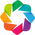

Row
    [0] HoloViews(DynamicMap, height=900, sizing_mode='fixed', width=900)
    [1] MoleculePanel(smiles_list=['Cn1c(C(=O)NC[C@@H]2CCC[C...])

In [8]:
%output size = 300
holoviews.extension('bokeh') # for colab notebooks, include in every cell

plot = view_UMAP(embedding = embedding)
roi_box_to_molecule_panel(
    plot,
    dataset = data,
    smiles_field = smiles_field)